# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [117]:
import tensorflow as tf
from scipy.io import loadmat

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [118]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [119]:
train_images, train_labels = train["X"], train["y"]
test_images, test_labels = test["X"], test["y"]

train_images = train_images / 255.0
test_images = test_images / 255.0


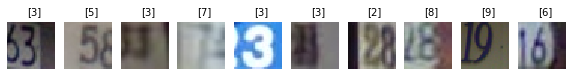

In [120]:
from random import sample
import matplotlib.pyplot as plt

random_ints = sample(range(0, len(train_images)), k=10)

fig, axis = plt.subplots(1, 10, figsize=(10, 1))

for ax, rand_int in zip(axis, random_ints):
    ax.set_axis_off()
    ax.imshow(train_images[:,:,:,rand_int])
    ax.text(13, -5, str(train_labels[rand_int]))


In [121]:
import numpy as np
import matplotlib.pyplot as plt

red_channels = train_images[:, :, 0, :]
green_channels = train_images[:, :, 1, :]
blue_channels = train_images[:, :, 2, :]

grayscale_train_images = (red_channels + green_channels + blue_channels) / 3


red_channels = test_images[:, :, 0, :]
green_channels = test_images[:, :, 1, :]
blue_channels = test_images[:, :, 2, :]

grayscale_test_images = (red_channels + green_channels + blue_channels) / 3


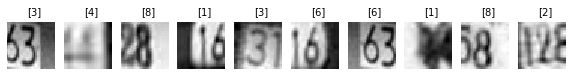

In [122]:
from random import sample
import matplotlib.pyplot as plt

random_ints = sample(range(0, len(train_images)), k=10)
sample_images = []

fig, axis = plt.subplots(1, 10, figsize=(10, 1))

for ax, rand_int in zip(axis, random_ints):
    ax.set_axis_off()
    ax.imshow(grayscale_train_images[:,:,rand_int], cmap=plt.get_cmap("gray"))
    ax.text(13, -5, str(train_labels[rand_int]))

In [123]:
# fix some axis layout in train and test images
train_images = np.moveaxis(train_images, -1, 0)
test_images = np.moveaxis(test_images, -1, 0)

In [124]:
# convert to OneHotEncoded array for train and test lables
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder().fit(train_labels)
train_labels = enc.transform(train_labels).toarray()
test_labels = enc.transform(test_labels).toarray()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [125]:
def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('loss: {loss:0.3f}'.format(loss=test_loss))
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))


In [126]:
from tensorflow.keras.callbacks import ModelCheckpoint

mlp_checkpoints_best_path = "mlp_checkpoints_best/checkpoint"
mlp_checkpoint_callback = ModelCheckpoint(
    filepath=mlp_checkpoints_best_path,
    save_freq="epoch",
    save_weights_only=True,
    save_best_only=True,
    monitor="val_loss",
    verbose=1,
)

In [127]:
from tensorflow.keras.callbacks import EarlyStopping
mlp_early_stopping_callback = EarlyStopping(
        monitor="loss",
        patience=3
    )

In [128]:
mlp_callbacks = [mlp_checkpoint_callback, mlp_early_stopping_callback, ]

In [129]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras import regularizers

def get_mlp_model():
    mlp_model = Sequential([
        Flatten(input_shape=train_images[0].shape),
        Dense(
            128,
            activation="relu",
        ),
        Dense(
            64,
            activation="relu",
        ),
        Dense(
            32,
            activation="relu",
        ),
        Dense(10, activation="softmax")
    ])

    mlp_model.summary()
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

    mlp_model.compile(
        optimizer=opt,
        loss="categorical_crossentropy",
        metrics=["acc"]
    )
    
    return mlp_model

    
    

In [130]:
mlp_model = get_mlp_model()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_50 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_51 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_52 (Dense)             (None, 10)                330       
Total params: 404,010
Trainable params: 404,010
Non-trainable params: 0
_________________________________________________________________


In [131]:

mlp_history = mlp_model.fit(
    train_images,
    train_labels,
    epochs=30,
    validation_split=0.15,
    batch_size=64,
    callbacks=mlp_callbacks
)

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
61824/62268 [============================>.] - ETA: 0s - loss: 2.2274 - acc: 0.1926
Epoch 00001: val_loss improved from inf to 2.11303, saving model to mlp_checkpoints_best/checkpoint
62268/62268 [==============================] - 5s 85us/sample - loss: 2.2267 - acc: 0.1929 - val_loss: 2.1130 - val_acc: 0.2614
Epoch 2/30
61312/62268 [============================>.] - ETA: 0s - loss: 1.7468 - acc: 0.4045
Epoch 00002: val_loss improved from 2.11303 to 1.40414, saving model to mlp_checkpoints_best/checkpoint
62268/62268 [==============================] - 5s 87us/sample - loss: 1.7427 - acc: 0.4059 - val_loss: 1.4041 - val_acc: 0.5503
Epoch 3/30
61952/62268 [============================>.] - ETA: 0s - loss: 1.3223 - acc: 0.5716
Epoch 00003: val_loss improved from 1.40414 to 1.24263, saving model to mlp_checkpoints_best/checkpoint
62268/62268 [==============================] - 5s 86us/sample - loss: 1.3214 - acc: 0.5720 - val_loss

Epoch 28/30
62144/62268 [============================>.] - ETA: 0s - loss: 0.7929 - acc: 0.7577
Epoch 00028: val_loss improved from 0.82856 to 0.80530, saving model to mlp_checkpoints_best/checkpoint
62268/62268 [==============================] - 5s 78us/sample - loss: 0.7930 - acc: 0.7577 - val_loss: 0.8053 - val_acc: 0.7540
Epoch 29/30
61696/62268 [============================>.] - ETA: 0s - loss: 0.7833 - acc: 0.7631
Epoch 00029: val_loss did not improve from 0.80530
62268/62268 [==============================] - 5s 75us/sample - loss: 0.7833 - acc: 0.7632 - val_loss: 0.8095 - val_acc: 0.7534
Epoch 30/30
61824/62268 [============================>.] - ETA: 0s - loss: 0.7798 - acc: 0.7641
Epoch 00030: val_loss did not improve from 0.80530
62268/62268 [==============================] - 4s 67us/sample - loss: 0.7792 - acc: 0.7641 - val_loss: 0.8268 - val_acc: 0.7504


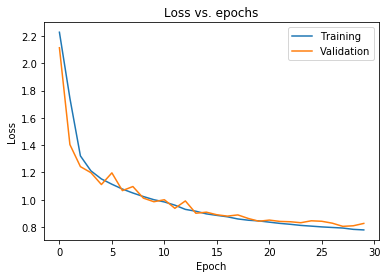

In [132]:
plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

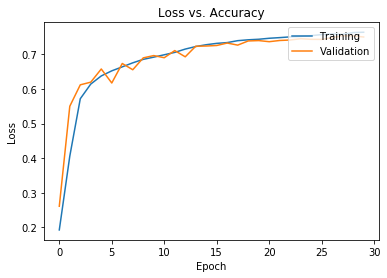

In [133]:
plt.plot(mlp_history.history['acc'])
plt.plot(mlp_history.history['val_acc'])
plt.title('Loss vs. Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [134]:
get_test_accuracy(mlp_model, test_images, test_labels)

loss: 0.954
accuracy: 0.717


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [135]:
from tensorflow.keras.callbacks import ModelCheckpoint

cnn_checkpoints_best_path = "cnn_checkpoints_best/checkpoint"
cnn_checkpoint_callback = ModelCheckpoint(
    filepath=cnn_checkpoints_best_path,
    save_freq="epoch",
    save_weights_only=True,
    save_best_only=True,
    monitor="val_loss",
    verbose=1,
)

In [136]:
from tensorflow.keras.callbacks import EarlyStopping
cnn_early_stopping_callback = EarlyStopping(
        monitor="loss",
        patience=3
    )

In [137]:
cnn_callbacks = [cnn_checkpoint_callback, cnn_early_stopping_callback, ]

In [141]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D

def get_cnn_model():
    
    cnn_model = Sequential([
            Conv2D(
                filters=32,
                input_shape=(32, 32, 3),
                kernel_size=(3, 3), 
                activation='relu',
            ),
            BatchNormalization(),
            MaxPooling2D(pool_size=(4, 4)),
            Conv2D(
                filters=16,
                input_shape=(32, 32, 3),
                kernel_size=(3, 3), 
                activation='relu',
            ),
            BatchNormalization(),
            Conv2D(
                filters=8,
                kernel_size=(3, 3),
                activation='relu',
            ),
            Flatten(name='flatten'),
            Dense(units=32, activation='relu'),
            Dense(units=10, activation='softmax')
        ])

    cnn_model.summary()
    
    cnn_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['acc']
    )
    
    return cnn_model
    

In [142]:
cnn_model = get_cnn_model()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_23 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 5, 5, 16)          4624      
_________________________________________________________________
batch_normalization_24 (Batc (None, 5, 5, 16)          64        
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 3, 3, 8)           1160      
_________________________________________________________________
flatten (Flatten)            (None, 72)              

In [143]:
cnn_history = cnn_model.fit(
    train_images,
    train_labels,
    epochs=30,
    validation_split=0.15,
    batch_size=64,
    callbacks=cnn_callbacks
)

Train on 62268 samples, validate on 10989 samples
Epoch 1/30
62080/62268 [============================>.] - ETA: 0s - loss: 1.1247 - acc: 0.6309
Epoch 00001: val_loss improved from inf to 0.85349, saving model to cnn_checkpoints_best/checkpoint
62268/62268 [==============================] - 9s 142us/sample - loss: 1.1235 - acc: 0.6314 - val_loss: 0.8535 - val_acc: 0.7399
Epoch 2/30
62080/62268 [============================>.] - ETA: 0s - loss: 0.6261 - acc: 0.8059
Epoch 00002: val_loss improved from 0.85349 to 0.67492, saving model to cnn_checkpoints_best/checkpoint
62268/62268 [==============================] - 9s 146us/sample - loss: 0.6256 - acc: 0.8060 - val_loss: 0.6749 - val_acc: 0.7855
Epoch 3/30
61952/62268 [============================>.] - ETA: 0s - loss: 0.5408 - acc: 0.8342
Epoch 00003: val_loss improved from 0.67492 to 0.55655, saving model to cnn_checkpoints_best/checkpoint
62268/62268 [==============================] - 8s 130us/sample - loss: 0.5407 - acc: 0.8342 - val_l

Epoch 29/30
61952/62268 [============================>.] - ETA: 0s - loss: 0.3253 - acc: 0.9012
Epoch 00029: val_loss did not improve from 0.39338
62268/62268 [==============================] - 7s 116us/sample - loss: 0.3254 - acc: 0.9011 - val_loss: 0.5019 - val_acc: 0.8449
Epoch 30/30
62208/62268 [============================>.] - ETA: 0s - loss: 0.3241 - acc: 0.9021
Epoch 00030: val_loss did not improve from 0.39338
62268/62268 [==============================] - 7s 116us/sample - loss: 0.3240 - acc: 0.9021 - val_loss: 0.4169 - val_acc: 0.8744


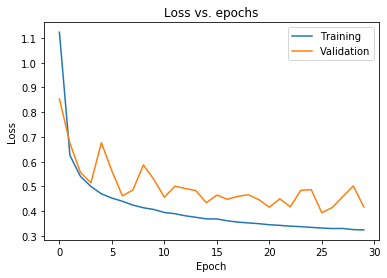

In [144]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

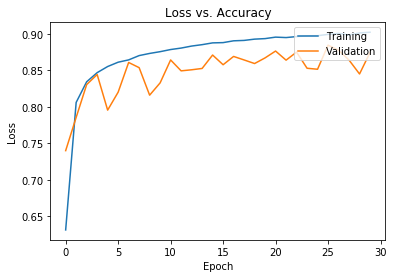

In [145]:
plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['val_acc'])
plt.title('Loss vs. Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [146]:
get_test_accuracy(cnn_model, test_images, test_labels)

loss: 0.442
accuracy: 0.868


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [288]:
def draw_predictions(test_samples, predictions):
    fig, axes = plt.subplots(5, 2, figsize=(16, 12))
    fig.subplots_adjust(hspace=0.4, wspace=-0.2)

    for ax, prediction, test_sample in zip(axes, mlp_predictions, test_samples):
        ax[0].imshow(np.squeeze(test_sample))
        ax[0].get_xaxis().set_visible(False)
        ax[0].get_yaxis().set_visible(False)
        ax[0].text(10., -1.5, f'Digit {prediction.argmax() + 1}')
        ax[1].bar(np.arange(1,11), prediction[0])
        ax[1].set_xticks(np.arange(1,11))
        ax[1].set_title("Categorical distribution. Model prediction")

In [289]:
predict_mlp_model = get_mlp_model()
predict_mlp_model.load_weights(mlp_checkpoints_best_path)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_63 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_64 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_65 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_66 (Dense)             (None, 10)                330       
Total params: 404,010
Trainable params: 404,010
Non-trainable params: 0
_________________________________________________________________


In [290]:
predict_cnn_model = get_cnn_model()
predict_cnn_model.load_weights(cnn_checkpoints_best_path)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_27 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 5, 5, 16)          4624      
_________________________________________________________________
batch_normalization_28 (Batc (None, 5, 5, 16)          64        
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 3, 3, 8)           1160      
_________________________________________________________________
flatten (Flatten)            (None, 72)              

In [291]:
from random import sample
import matplotlib.pyplot as plt

random_ints = sample(range(0, len(test_images)), k=5)

test_samples = [
    test_images[rand_int] for rand_int in random_ints
]


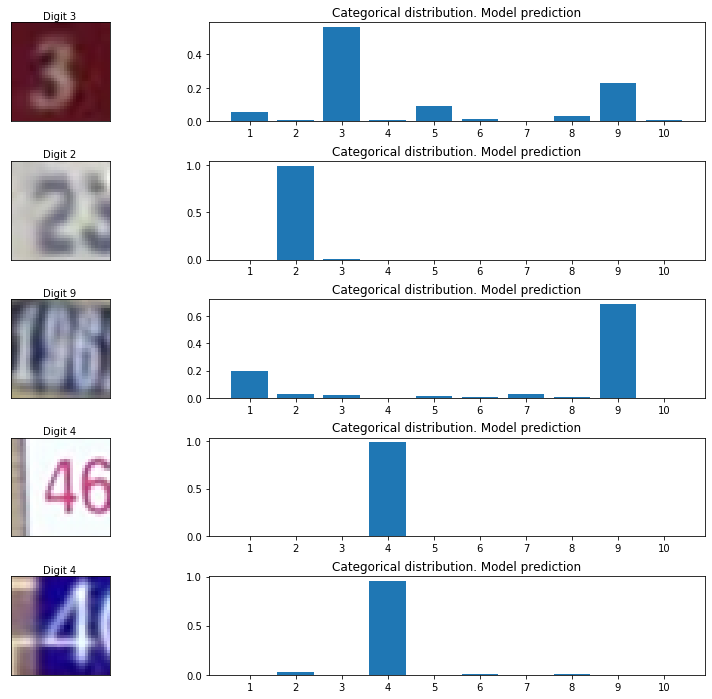

In [292]:
mlp_predictions = [
    mlp_model.predict(
        test_sample.reshape(
            (1, 32, 32, 3)
        )
    ) 
    for test_sample in test_samples
]

draw_predictions(test_samples, mlp_predictions)


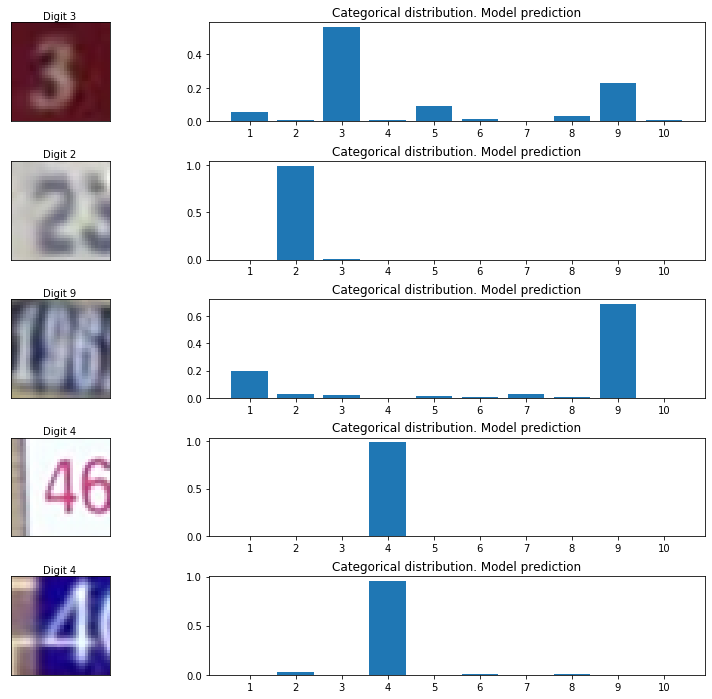

In [293]:
cnn_predictions = [
    cnn_model.predict(
        test_sample.reshape(
            (1, 32, 32, 3)
        )
    ) 
    for test_sample in test_samples
]

draw_predictions(test_samples, cnn_predictions)
